<a href="https://colab.research.google.com/github/adnan-kibria/cvpr_assignment/blob/main/MID/assignment_1_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import cv2
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
dataset = '/content/drive/MyDrive/Dataset/animal_dataset'
categories = os.listdir(dataset)
categories = [c for c in categories if not c.startswith('.')]
print(categories)

['dog', 'panda', 'cat']


In [71]:
mapLabels = {categories[i]: i for i in range(len(categories))}
print("Label Mapping:", mapLabels)

Label Mapping: {'dog': 0, 'panda': 1, 'cat': 2}


In [72]:
data = []

for category in tqdm(categories, desc = 'Loading Images: '):
    path = os.path.join(dataset, category)
    classNumber = mapLabels[category]

    for img in os.listdir(path):
        imgArray = os.path.join(path, img)

        try:
            img = cv2.imread(imgArray, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Skipping corrupted file: {imgArray}")
                continue

            img = cv2.resize(img, (32, 32))
            img = img / 255.0

            data.append((img, classNumber))

        except Exception as e:
            print(f"Error loading {imgArray}: {e}")
            continue

print("\nTotal Images:", len(data))

Loading Images: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it]


Total Images: 300


In [73]:
random.shuffle(data)

X = np.array([img for img, label in data]).reshape(-1, 32, 32, 1)
Y = np.array([label for img, label in data])

print("Total samples:", X.shape)

Total samples: (300, 32, 32, 1)


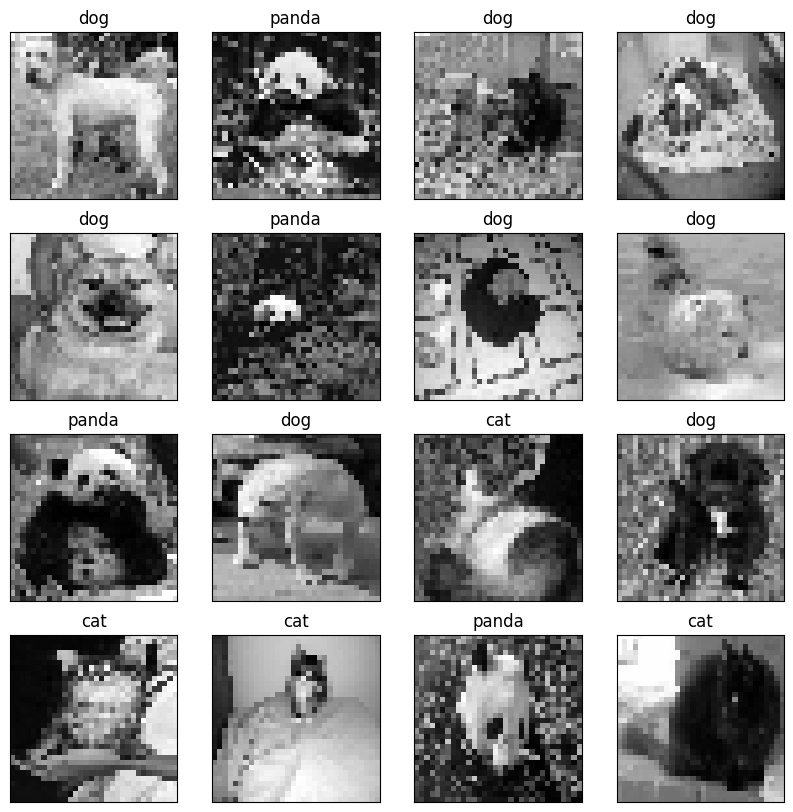

In [74]:
plt.figure(figsize=(10,10))
for i in range(16):
    index = random.randint(0, len(X)-1)
    plt.subplot(4,4,i+1)
    plt.imshow(X[index].reshape(32,32), cmap='gray')
    classNumber = Y[index]
    className = [k for k,v in mapLabels.items() if v == classNumber][0]
    plt.title(className)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [75]:
XFlat = X.reshape(len(X), -1)

In [76]:
def l1(x1, x2):
    return np.sum(np.abs(x1 - x2))

def l2(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [77]:
def knnPredict(xTrain, yTrain, xTest, k = 5, distance_metric = "L2"):
    distances = []

    for i in range(len(xTrain)):
        if distance_metric == "L1":
            dist = l1(xTrain[i], xTest)
        else:
            dist = l2(xTrain[i], xTest)

        distances.append((dist, yTrain[i]))

    distances.sort(key=lambda x: x[0])
    neighbors = [distances[i][1] for i in range(k)]
    return max(set(neighbors), key=neighbors.count)

In [78]:
def fiveFoldCrossValidation(X, y, kValues, distance="L2"):
    foldSize = len(X) // 5
    results = {k: [] for k in kValues}

    for fold in range(5):
        start = fold * foldSize
        end = start + foldSize

        xValue = X[start:end]
        yValue = Y[start:end]

        xTrainFold = np.concatenate((X[:start], X[end:]))
        yTrainFold = np.concatenate((Y[:start], Y[end:]))

        print(f"\nFold {fold+1} — Distance: {distance}")

        for k in kValues:
            correct = 0
            for i in range(len(xValue)):
                pred = knnPredict(xTrainFold, yTrainFold, xValue[i], k, distance)
                if pred == yValue[i]:
                    correct += 1

            acc = correct / len(xValue)
            results[k].append(acc)
            print(f"K={k} Accuracy: {acc*100:.2f}%")

    return results

kValues = [1,3,5,7, 9]

l2Results = fiveFoldCrossValidation(XFlat, Y, kValues, distance="L2")
l1Results = fiveFoldCrossValidation(XFlat, Y, kValues, distance="L1")


Fold 1 — Distance: L2
K=1 Accuracy: 28.33%
K=3 Accuracy: 21.67%
K=5 Accuracy: 30.00%
K=7 Accuracy: 38.33%
K=9 Accuracy: 31.67%

Fold 2 — Distance: L2
K=1 Accuracy: 35.00%
K=3 Accuracy: 41.67%
K=5 Accuracy: 40.00%
K=7 Accuracy: 38.33%
K=9 Accuracy: 46.67%

Fold 3 — Distance: L2
K=1 Accuracy: 35.00%
K=3 Accuracy: 36.67%
K=5 Accuracy: 36.67%
K=7 Accuracy: 35.00%
K=9 Accuracy: 35.00%

Fold 4 — Distance: L2
K=1 Accuracy: 36.67%
K=3 Accuracy: 36.67%
K=5 Accuracy: 33.33%
K=7 Accuracy: 41.67%
K=9 Accuracy: 40.00%

Fold 5 — Distance: L2
K=1 Accuracy: 36.67%
K=3 Accuracy: 38.33%
K=5 Accuracy: 35.00%
K=7 Accuracy: 30.00%
K=9 Accuracy: 31.67%

Fold 1 — Distance: L1
K=1 Accuracy: 31.67%
K=3 Accuracy: 40.00%
K=5 Accuracy: 31.67%
K=7 Accuracy: 38.33%
K=9 Accuracy: 40.00%

Fold 2 — Distance: L1
K=1 Accuracy: 35.00%
K=3 Accuracy: 40.00%
K=5 Accuracy: 41.67%
K=7 Accuracy: 41.67%
K=9 Accuracy: 43.33%

Fold 3 — Distance: L1
K=1 Accuracy: 41.67%
K=3 Accuracy: 36.67%
K=5 Accuracy: 38.33%
K=7 Accuracy: 45.0

In [79]:
def summarizeResults(results, name):
    print(f'Summary result of {name}')
    averageAccuracy = {}

    for k, accList in results.items():
        average = np.mean(accList)
        averageAccuracy[k] = average
        print(f"K={k} → Avg Accuracy: {average*100:.2f}%")

    # best k
    bestK = max(averageAccuracy, key=averageAccuracy.get)
    bestAccuracy = averageAccuracy[bestK]

    print(f"Best K for {name} = {bestK} with Accuracy = {bestAccuracy*100:.2f}%\n")
    return bestAccuracy, bestK

l1bestAccuracy, l1BestK = summarizeResults(l1Results, "L1(Manhattan) Distance")
l2bestAccuracy, l2BestK = summarizeResults(l2Results, "L2(Euclidean) Distance")

if l2bestAccuracy > l1bestAccuracy:
    print(f"L2(Euclidean) distance is better ({l2bestAccuracy*100:.2f}%) compared to L1(Manhattan) distance ({l1bestAccuracy*100:.2f}%)")
else:
    print(f"L1(Manhattan) distance is better ({l1bestAccuracy*100:.2f}%) compared to L2(Euclidean) distance ({l2bestAccuracy*100:.2f}%)")


Summary result of L1(Manhattan) Distance
K=1 → Avg Accuracy: 36.00%
K=3 → Avg Accuracy: 38.00%
K=5 → Avg Accuracy: 37.00%
K=7 → Avg Accuracy: 39.67%
K=9 → Avg Accuracy: 40.67%
Best K for L1(Manhattan) Distance = 9 with Accuracy = 40.67%

Summary result of L2(Euclidean) Distance
K=1 → Avg Accuracy: 34.33%
K=3 → Avg Accuracy: 35.00%
K=5 → Avg Accuracy: 35.00%
K=7 → Avg Accuracy: 36.67%
K=9 → Avg Accuracy: 37.00%
Best K for L2(Euclidean) Distance = 9 with Accuracy = 37.00%

L1(Manhattan) distance is better (40.67%) compared to L2(Euclidean) distance (37.00%)


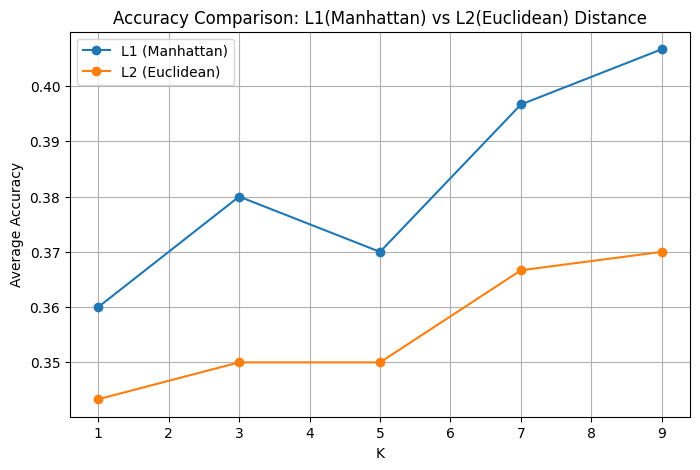

In [80]:
averageL1 = [np.mean(l1Results[k]) for k in kValues]
averageL2 = [np.mean(l2Results[k]) for k in kValues]

plt.figure(figsize=(8,5))
plt.plot(kValues, averageL1, marker='o', label="L1 (Manhattan)")
plt.plot(kValues, averageL2, marker='o', label="L2 (Euclidean)")
plt.xlabel("K")
plt.ylabel("Average Accuracy")
plt.title("Accuracy Comparison: L1(Manhattan) vs L2(Euclidean) Distance")
plt.grid(True)
plt.legend()
plt.show()

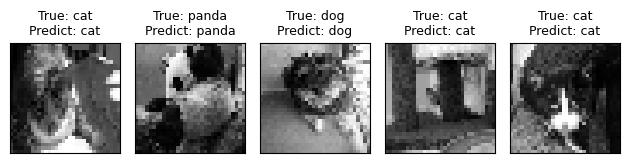

In [81]:
def top5Predictions(index):
    distances = []
    for i in range(len(XFlat)):
        dist = l2(XFlat[index], XFlat[i])
        distances.append((dist, Y[i]))

    distances.sort(key=lambda x: x[0])
    top5 = distances[:5]
    return [y for d, y in top5]

for i in range(5):
    index = random.randint(0, len(XFlat) - 1)

    img = X[index].reshape(32,32)

    tLabel = Y[index]
    trueLabels = list(mapLabels.keys())[list(mapLabels.values()).index(tLabel)]

    preds = top5Predictions(index)
    p = preds[0]
    predictionLabels = list(mapLabels.keys())[list(mapLabels.values()).index(p)]

    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {trueLabels}\nPredict: {predictionLabels}", fontsize=9)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
plt.show()